## Домашнее задание. Обучение с учителем.

### Задание.
***
Домашнее задание по дисциплине направлено на решение комплексной задачи машинного обучения с учителем. Домашнее задание включает выполнение следующих шагов:

1. Поиск и выбор набора данных для построения модели машинного обучения. На основе выбранного набора данных строится модель машинного обучения для решения или задачи классификации, или задачи регрессии.

2. Для выбранного датасета (датасетов) на основе материалов лекций, в целях улучшения выборки, решить следующие задачи (если это необходимо в данном датасете):
* устранение пропусков в данных;
* кодирование категориальных признаков;
* нормализацию числовых признаков;
* масштабирование признаков;
* обработку выбросов для числовых признаков;
* обработку нестандартных признаков (которые не является числовым или категориальным);
* отбор признаков, наиболее подходящих для построения модели;
* устранение дисбаланса классов в случае решения задачи классификации на дисбалансированной выборке.
3. Обучить модель и оценить метрики качества для двух выборок :
исходная выборка, которая содержит только минимальную предобработку данных, необходимую для построения модели (например, кодирование категориальных признаков).
улучшенная выборка, полученная в результате полной предобработки данных в пункте 2.

4. Построить модель с использованием произвольной библиотеки AutoML.

5. Сравнить метрики для трех полученных моделей.

### Выполнение.
***
Задание буду выполнять на датасете ["Computer Parts (CPUs and GPUs)"](https://www.kaggle.com/iliassekkaf/computerparts). Датасет содержит значения различных характеристик по CPU GPU. В датасете есть как числовые и категориальные признаки так и нестандартные признаки. Есть колонки с пропусками, ненормированными значениями. Датасет состоит из двух наборов данных по CPU и по GPU. Анализировать будем CPU файл.  
В ходе выполненния ДЗ будет решаться задача классификации.

Загрузка и обзор датасета:

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

dataset = pd.read_csv('../data/Intel_CPUs.csv', sep=",")
dataset

,Product_Collection,Vertical_Segment,Processor_Number,Status,Launch_Date,Lithography,Recommended_Customer_Price,nb_of_Cores,nb_of_Threads,Processor_Base_Frequency,...,T,Intel_Hyper_Threading_Technology_,Intel_Virtualization_Technology_VTx_,Intel_64_,Instruction_Set,Instruction_Set_Extensions,Idle_States,Thermal_Monitoring_Technologies,Secure_Key,Execute_Disable_Bit
0,7th Generation Intel® Core™ i7 Processors,Mobile,i7-7Y75,Launched,Q3'16,14 nm,$393.00,2,4.0,1.30 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
1,8th Generation Intel® Core™ i5 Processors,Mobile,i5-8250U,Launched,Q3'17,14 nm,$297.00,4,8.0,1.60 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
2,8th Generation Intel® Core™ i7 Processors,Mobile,i7-8550U,Launched,Q3'17,14 nm,$409.00,4,8.0,1.80 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
3,Intel® Core™ X-series Processors,Desktop,i7-3820,End of Life,Q1'12,32 nm,$305.00,4,8.0,3.60 GHz,...,66.8°C,Yes,Yes,Yes,64-bit,"SSE4.2, AVX, AES",Yes,Yes,NaN,Yes
4,7th Generation Intel® Core™ i5 Processors,Mobile,i5-7Y57,Launched,Q1'17,14 nm,$281.00,2,4.0,1.20 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,6th Generation Intel® Core™ m Processors,Mobile,M5-6Y54,Launched,Q3'15,14 nm,$281.00,2,4.0,1.10 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
2279,6th Generation Intel® Core™ m Processors,Mobile,M5-6Y57,Launched,Q3'15,14 nm,$281.00,2,4.0,1.10 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
2280,6th Generation Intel® Core™ m Processors,Mobile,M7-6Y75,Launched,Q3'15,14 nm,$393.00,2,4.0,1.20 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
2281,5th Generation Intel® Core™ i7 Processors,Mobile,i7-5550U,Launched,Q1'15,14 nm,$426.00,2,4.0,2.00 GHz,...,105°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes


### Устранение пропусков в данных:
Удалим признаки, число пропущенных значений в которых более 30%:

In [2]:
def get_missing_columns(dataset, percent_min = 0, percent_max = 100, is_print = True):
    columns_with_omissions = []
    row_count = dataset.shape[0]
    for col in dataset.columns:
        percent = round((dataset[col].isnull().sum() / row_count) * 100)
        if is_print:
            print("\"{0}\" ({1}) пропущенно {2}% ".format(col, dataset[col].dtype, percent))
        if percent > percent_min and percent <= percent_max:
            columns_with_omissions.append(col)
    return columns_with_omissions

del_cols_names = get_missing_columns(dataset, percent_min=30)

for col in del_cols_names:
    dataset = dataset.drop(col, axis = 1)

print('Удалено {} признаков: '.format(len(del_cols_names)))
print(del_cols_names)

"Product_Collection" (object) пропущенно 0% 
"Vertical_Segment" (object) пропущенно 0% 
"Processor_Number" (object) пропущенно 15% 
"Status" (object) пропущенно 0% 
"Launch_Date" (object) пропущенно 18% 
"Lithography" (object) пропущенно 3% 
"Recommended_Customer_Price" (object) пропущенно 43% 
"nb_of_Cores" (int64) пропущенно 0% 
"nb_of_Threads" (float64) пропущенно 37% 
"Processor_Base_Frequency" (object) пропущенно 1% 
"Max_Turbo_Frequency" (object) пропущенно 60% 
"Cache" (object) пропущенно 1% 
"Bus_Speed" (object) пропущенно 13% 
"TDP" (object) пропущенно 3% 
"Embedded_Options_Available" (object) пропущенно 0% 
"Conflict_Free" (object) пропущенно 47% 
"Max_Memory_Size" (object) пропущенно 39% 
"Memory_Types" (object) пропущенно 39% 
"Max_nb_of_Memory_Channels" (float64) пропущенно 38% 
"Max_Memory_Bandwidth" (object) пропущенно 50% 
"ECC_Memory_Supported" (object) пропущенно 34% 
"Processor_Graphics_" (float64) пропущенно 100% 
"Graphics_Base_Frequency" (object) пропущенно 63% 
"

In [3]:
# Статистика числа пропусков для каждого оставшегося признака:
get_missing_columns(dataset)
print("Форма датасета: {}".format(str(dataset.shape)))

"Product_Collection" (object) пропущенно 0% 
"Vertical_Segment" (object) пропущенно 0% 
"Processor_Number" (object) пропущенно 15% 
"Status" (object) пропущенно 0% 
"Launch_Date" (object) пропущенно 18% 
"Lithography" (object) пропущенно 3% 
"nb_of_Cores" (int64) пропущенно 0% 
"Processor_Base_Frequency" (object) пропущенно 1% 
"Cache" (object) пропущенно 1% 
"Bus_Speed" (object) пропущенно 13% 
"TDP" (object) пропущенно 3% 
"Embedded_Options_Available" (object) пропущенно 0% 
"T" (object) пропущенно 11% 
"Intel_Hyper_Threading_Technology_" (object) пропущенно 11% 
"Intel_Virtualization_Technology_VTx_" (object) пропущенно 4% 
"Intel_64_" (object) пропущенно 13% 
"Instruction_Set" (object) пропущенно 6% 
"Idle_States" (object) пропущенно 24% 
"Execute_Disable_Bit" (object) пропущенно 13% 
Форма датасета: (2283, 19)


In [4]:
#Стоит исключить ряд признаков, которые не будут полезны при построении моделей ML и/или содержат также большое число пропусков:
dataset = dataset.drop(['Bus_Speed', 'Idle_States', 'Execute_Disable_Bit', 'Processor_Number', "Embedded_Options_Available",], axis = 1)

Если число пропущенных значений мало (менее 7%), то удалим строки:

In [5]:
row_before_dpop = dataset.shape[0]
cols_with_nulls_rows = get_missing_columns(dataset, percent_max = 7, is_print = False)
print("В следующих колонках будут удалены строки: {}".format(str(cols_with_nulls_rows)))
dataset = dataset.dropna(axis = 0, subset = cols_with_nulls_rows)        
row_after_dpop = dataset.shape[0]
print("Число удаленных строк: {}".format(row_before_dpop - row_after_dpop))
print("Оставшиеся признаки с пропусками: {}".format(str(get_missing_columns(dataset, is_print = False))))

В следующих колонках будут удалены строки: ['Lithography', 'Processor_Base_Frequency', 'Cache', 'TDP', 'Intel_Virtualization_Technology_VTx_', 'Instruction_Set']
Число удаленных строк: 225
Оставшиеся признаки с пропусками: ['Launch_Date', 'T', 'Intel_Hyper_Threading_Technology_', 'Intel_64_']


### Преобразование не стандартных признаков  
Признак Т - температура, по существу числовое значение. Необходимо преобразовать его к float типу. Часть значений в колонке Т сложно однозначно итерпретировать (например: "C1+D1=75°C; M0=72°C"), заменим их пустыми значениями:

In [6]:
regex_is_valid = r'^[0-9\.°\sCС]*$'
not_valid = []
for val in dataset['T']:
    if not re.match(regex_is_valid, str(val)):
        not_valid.append(val)        
dataset['T'] = dataset['T'].replace(list(set(not_valid)), np.nan)

Распарсим float значения:

In [7]:
#Теперь все красиво, можем начать преобразовывать в числовые данные:
regex_val = r'[0-9\.]{1,7}'
col_name = "T"
for val in dataset[col_name]:
    if type(val) is not str:
        continue
    match = re.search(regex_val, val)
    if not match:
        raise BaseException("Не удалось распарсить {}".format(val))
    else:
        dataset[col_name] = dataset[col_name].replace([val], match.group())
dataset[col_name] = dataset[col_name].astype(float)

Также TDP - это по существу числовой признак, преобразуем его:

In [8]:
col_name = "TDP"
for val in dataset[col_name]:
    if type(val) is not str:
        continue
    num = float(str(val).split(" ")[0])
    dataset[col_name] = dataset[col_name].replace([val], num)
dataset[col_name] = dataset[col_name].astype(float)
dataset[col_name].value_counts()

35.0     234
65.0     150
95.0     104
45.0      88
130.0     87
        ... 
20.5       1
54.3       1
260.0      1
66.8       1
3.5        1
Name: TDP, Length: 221, dtype: int64

Признак *Processor_Base_Frequency* также требует предобработки. В датасете это не числовое значение (type `object`), но на деле представляет собой `float` значение. Причем частоты представлены в MHz и GHz, что также требует конвертации.  
Попробуем распрарсить числовые значения и привести их к одинаковой размерности - MHz.

In [9]:
regex_ghz = r"[0-9\.]*(?= GHz)"
regex_mhz = r"[0-9\.]*(?= MHz)"
col_name = "Processor_Base_Frequency"
for val in dataset[col_name]:
    if type(val) is not str:
        continue
    match = re.search(regex_ghz, str(val))
    if match:
        dataset[col_name] = dataset[col_name].replace([val], float(match.group()) * 1000)
    else:
        match = re.search(regex_mhz, str(val))
        if not match:        
            raise BaseException("Не удалось распарсить {}".format(val))
        else:
            dataset[col_name] = dataset[col_name].replace([val], float(match.group()))
dataset[col_name] = dataset[col_name].astype(int)

### Заполним пропуски
Запоним пропуски в категориальных значениях с помощью `SimpleImputer` со статегией `most_frequent`:

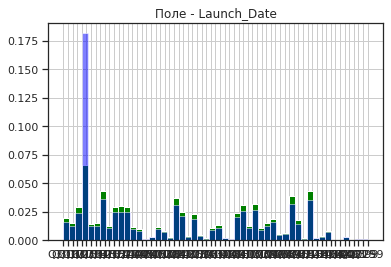

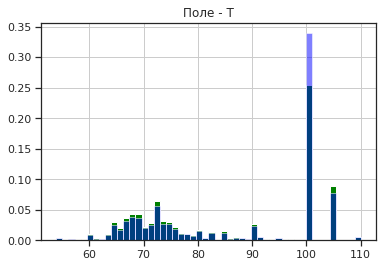

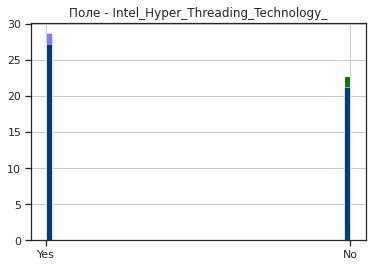

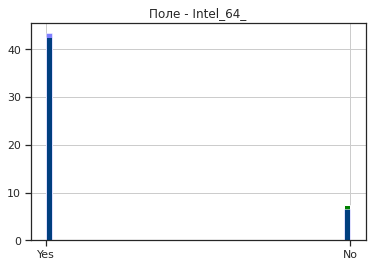

"Product_Collection" (object) пропущенно 0% 
"Vertical_Segment" (object) пропущенно 0% 
"Status" (object) пропущенно 0% 
"Launch_Date" (object) пропущенно 0% 
"Lithography" (object) пропущенно 0% 
"nb_of_Cores" (int64) пропущенно 0% 
"Processor_Base_Frequency" (int64) пропущенно 0% 
"Cache" (object) пропущенно 0% 
"TDP" (float64) пропущенно 0% 
"T" (float64) пропущенно 0% 
"Intel_Hyper_Threading_Technology_" (object) пропущенно 0% 
"Intel_Virtualization_Technology_VTx_" (object) пропущенно 0% 
"Intel_64_" (object) пропущенно 0% 
"Instruction_Set" (object) пропущенно 0% 


[]

In [10]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, density=True, color='blue', alpha=0.5)
        plt.show()

before_imputing = dataset.copy();
imputing_cols = get_missing_columns(dataset, is_print = False)

imputer = SimpleImputer(strategy = "most_frequent")
for col in imputing_cols:
    dataset[col] = imputer.fit_transform(dataset[[col]])

plot_hist_diff(before_imputing, dataset, imputing_cols);
get_missing_columns(dataset)

### Поиск дисбалансных признаков  
Перед тем как перейти к кодированию категориальных признаков, изучим наличие дисбалансных классов:

In [11]:
categories_all = ["Product_Collection", "Status", "Vertical_Segment", "Launch_Date", "Lithography", "Cache", 
              "Instruction_Set", "Intel_Hyper_Threading_Technology_", "Intel_Virtualization_Technology_VTx_", 
              "Intel_64_"]


for cat in categories_all:
    classes = dataset[cat].value_counts()
    max_cls_count = classes[0]
    min_cls_count = classes[len(classes) - 1]
    print("{} imbalance ratio = {}".format(cat, round(max_cls_count / min_cls_count)))

Product_Collection imbalance ratio = 187
Status imbalance ratio = 132
Vertical_Segment imbalance ratio = 4
Launch_Date imbalance ratio = 455
Lithography imbalance ratio = 27
Cache imbalance ratio = 208
Instruction_Set imbalance ratio = 56
Intel_Hyper_Threading_Technology_ imbalance ratio = 1
Intel_Virtualization_Technology_VTx_ imbalance ratio = 250
Intel_64_ imbalance ratio = 7


Очевидно во многих признаках присутстствуют дизбаласнные классы :(.

### Кодирование категориальных значений
В случае минимальной предобработки датасета выполним кодирование всех признаков с помощью `LabelEncoder`:

In [12]:
dataset_simple = dataset.copy()
for cat in categories_all:
    dataset_simple[cat] = LabelEncoder().fit_transform(dataset_simple[cat])
    dataset_simple[cat] = dataset_simple[cat].astype(int)

Для более глубокой предобработки выполним кодирование части признаков с помощью `LabelEncoder`, а часть категориальных признаков, в которых мало уникальных категорий (например значения yes/no) или категории "не упорядоченные" с помощью `OneHotEncoder`, чтобы не увеличивать сильно признаковое пространство.

In [13]:
dataset_complex = dataset.copy()
categories_le = []
categories_oh = []
for col in categories_all:
    if (len(dataset[col].value_counts()) < 4):
        categories_oh.append(col)
    else:
        categories_le.append(col)

for cat in categories_le:
    dataset_complex[cat] = LabelEncoder().fit_transform(dataset_complex[cat])
    dataset_complex[cat] = dataset_complex[cat].astype(int)
for cat in categories_oh:
    dataset_complex = pd.concat([dataset_complex, pd.get_dummies(dataset_complex[cat],
                                                                 prefix = cat, drop_first = True)],axis = 1)
    dataset_complex = dataset_complex.drop(cat, axis = 1)
dataset_complex

,Product_Collection,Vertical_Segment,Status,Launch_Date,Lithography,nb_of_Cores,Processor_Base_Frequency,Cache,TDP,T,Instruction_Set_64-bit,Instruction_Set_Itanium 64-bit,Intel_Hyper_Threading_Technology__Yes,Intel_Virtualization_Technology_VTx__See Ordering Info,Intel_Virtualization_Technology_VTx__Yes,Intel_64__Yes
0,13,2,3,49,1,2,1300,65,4.5,100.0,1,0,1,0,1,1
1,15,2,3,50,1,4,1600,82,15.0,100.0,1,0,1,0,1,1
2,16,2,3,50,1,4,1800,87,15.0,100.0,1,0,1,0,1,1
3,29,0,2,12,5,4,3600,8,130.0,66.8,1,0,1,0,1,1
4,12,2,3,17,1,2,1200,65,4.5,100.0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,10,2,3,48,1,2,1100,65,4.5,100.0,1,0,1,0,1,1
2279,10,2,3,48,1,2,1100,65,4.5,100.0,1,0,1,0,1,1
2280,10,2,3,48,1,2,1200,65,4.5,100.0,1,0,1,0,1,1
2281,6,2,3,15,1,2,2000,65,15.0,105.0,1,0,1,0,1,1


### Нормализация значений
Посмотрим как распределены числовые признаки, и нормализуем их с помощью преобразования логарифмического преобразования.

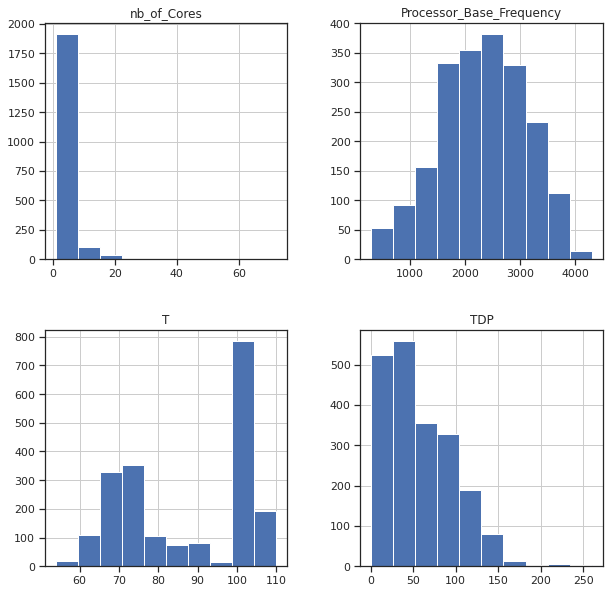

In [14]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
num_cols = ["nb_of_Cores", "Processor_Base_Frequency", "T", "TDP"]
dataset_complex[num_cols].hist(figsize=(10, 10))
plt.show()

Оптимальное значение λ = 0.37242146081505817


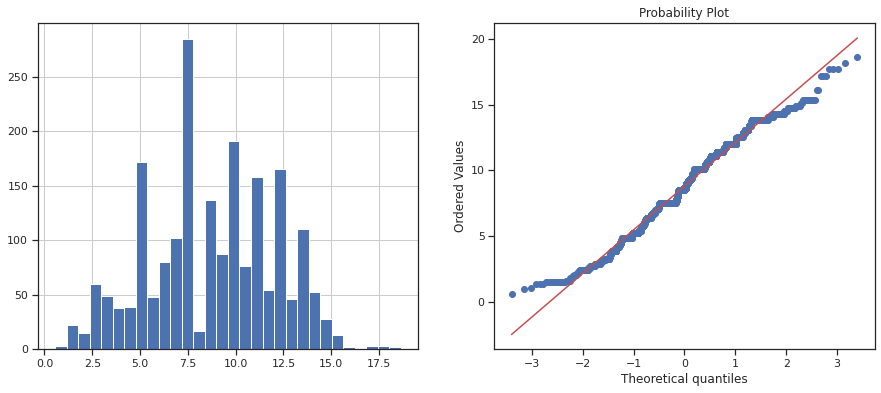

In [15]:
# Необходимо преобразовать данные к действительному типу
dataset_complex['TDP'] = dataset_complex['TDP'].astype('float')
dataset_complex['TDP'], param = stats.yeojohnson(dataset_complex['TDP']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(dataset_complex, 'TDP')

### Обработка выбросов
***
Изучим числовые признаки на наличие выбросов:

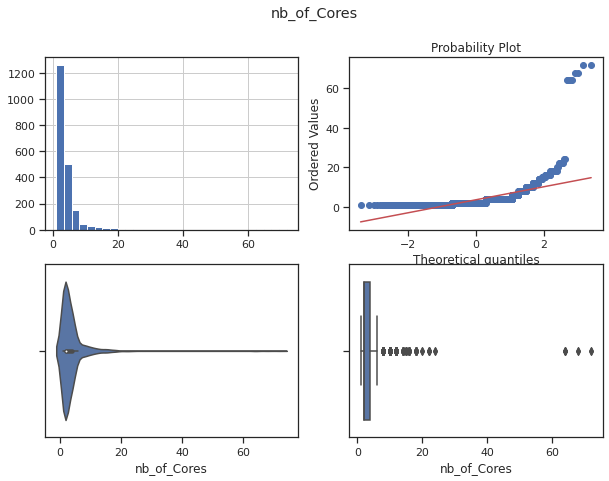

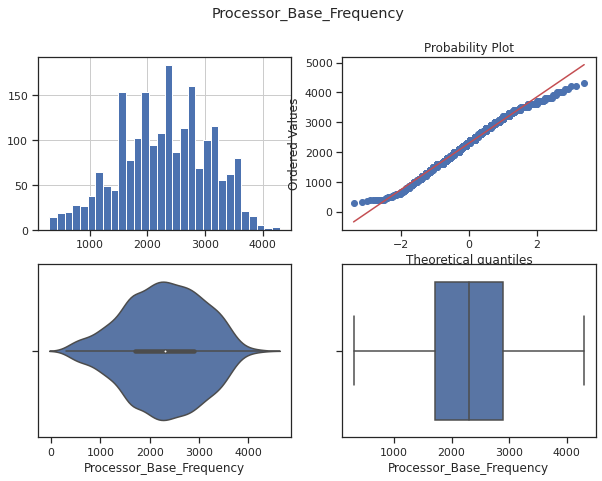

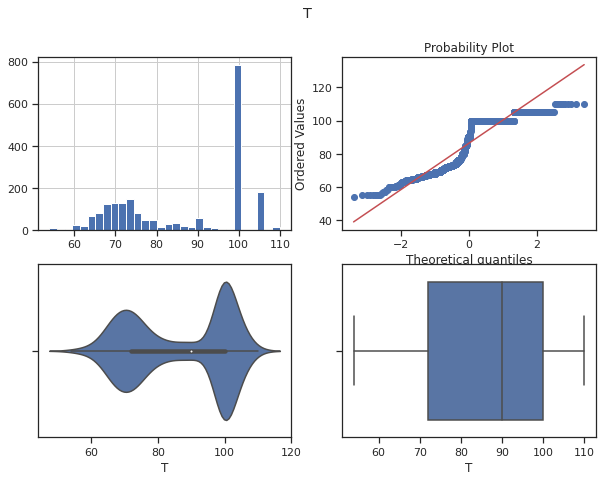

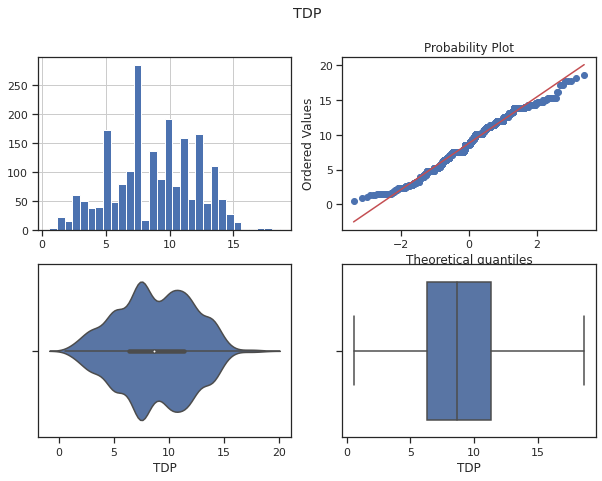

In [16]:
def diagnostic_plots(df, variable):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(variable)
    plt.show()

for col in num_cols:
    diagnostic_plots(dataset_complex, col)

Как видим распределение признака `nb_of_Cores` ассиметричное, однако присутствуют выбросы. Выборсы можно определять по правилу трех сигм или 5% и 95% квантилей. Воспользуемся последним правилом.  
Устраним выбросы с помощью *замены выбросов* на найденные верхнюю и нижнюю границы:

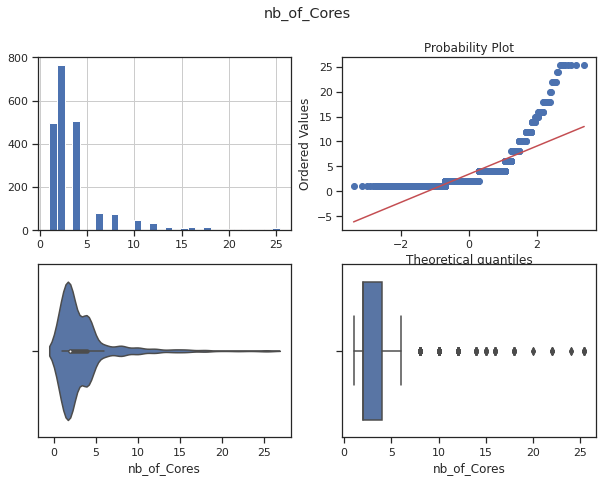

In [17]:
col_with_outlier = "nb_of_Cores"
K2 = 1.5
IQR = dataset_complex[col].quantile(0.75) - dataset_complex[col_with_outlier].quantile(0.25)
lower_boundary = dataset_complex[col].quantile(0.25) - (K2 * IQR)
upper_boundary = dataset_complex[col].quantile(0.75) + (K2 * IQR)
outliers_temp = np.where(dataset_complex[col_with_outlier] > upper_boundary, True, 
                         np.where(dataset_complex[col_with_outlier] < lower_boundary, True, False))

dataset_complex[col_with_outlier] = np.where(dataset_complex[col_with_outlier] > upper_boundary, upper_boundary, 
                                    np.where(dataset_complex[col_with_outlier] < lower_boundary, lower_boundary, dataset_complex[col_with_outlier]))
diagnostic_plots(dataset_complex, col_with_outlier)

### Масштабирование
Т.к. в качестве модели будет использоваться RandomForestRegressor, выполнять масштабирование не обязательно.
### Отбор признаков
Воспользуемся heat map для обнаружения коррелияций:

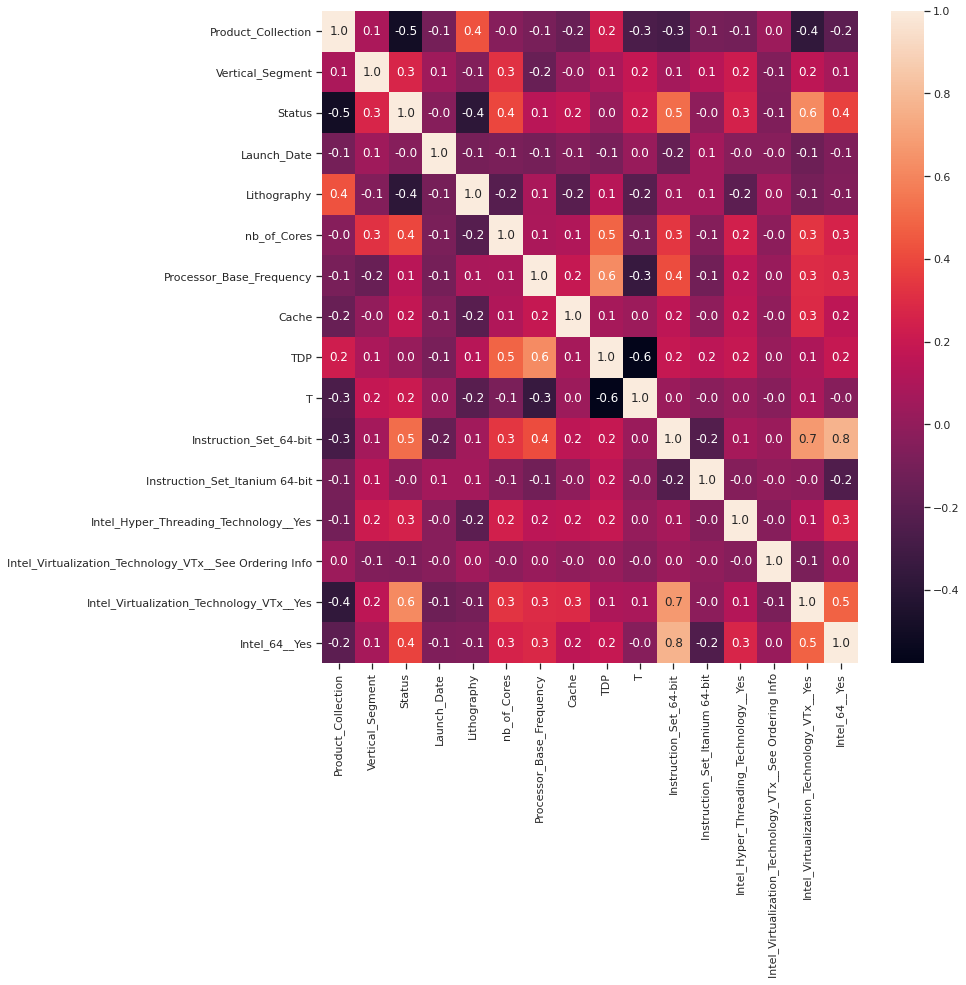

In [18]:
_, ax = plt.subplots(figsize = (12,12))
sns.heatmap(dataset_complex.corr(), annot=True, fmt='.1f', ax = ax)
plt.show()

### Построение моделей
Классический способ:

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from typing import Dict

def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = round(accuracy_score(temp_data_flt['t'].values,temp_data_flt['p'].values)*100,2)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

y_name = "Vertical_Segment"
x_complex = list(dataset_complex.columns)
x_complex.remove(y_name)
x_simple = list(dataset_simple.columns)
x_simple.remove(y_name)
x_data = {"dataset_complex" : dataset_complex[x_complex], 
          "dataset_simple" : dataset_simple[x_simple]}
dataset_complex[y_name] = dataset_complex[y_name].astype(int)

model = RandomForestClassifier(n_estimators=50, random_state=1)
results = {}
for data_name, x_data in x_data.items():
    X_train, X_test, y_train, y_test = train_test_split(x_data, dataset_complex[y_name],
                                                        test_size=0.3, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = accuracy_score_for_classes(y_test, y_pred)  
    results[data_name] = scores

Построим графики метрик качества модели

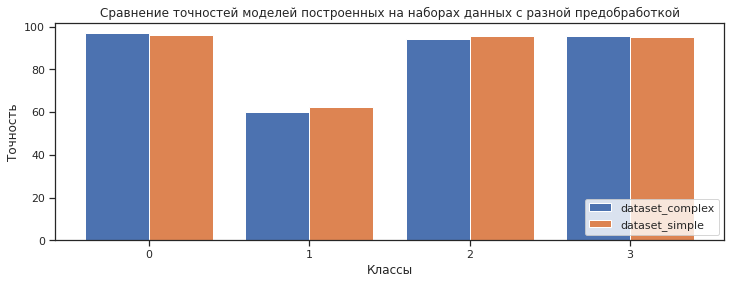

In [20]:
index = np.arange(len(dataset[y_name].value_counts()))
bar_width = 0.4
fig, ax = plt.subplots(figsize = (12,4))
ax.bar(index, results["dataset_complex"].values(), bar_width, label="dataset_complex")
ax.bar(index + bar_width, results["dataset_simple"].values(), bar_width, label="dataset_simple")

ax.set_ylabel('Точность')
ax.set_xlabel('Классы')
ax.set_title("Сравнение точностей моделей построенных на наборах данных с разной предобработкой")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend(loc = "lower right")

plt.show()

Auto ML:

In [21]:
from supervised.automl import AutoML

model = AutoML()
X_train, X_test, y_train, y_test = train_test_split(dataset[x_simple], dataset[y_name], test_size=0.3, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
results["auto_ml"] = accuracy_score_for_classes(y_test, y_pred)  

AutoML directory: AutoML_3
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 1.286907 trained in 0.62 seconds
2_DecisionTree logloss 0.716295 trained in 28.01 seconds
3_Linear logloss 0.615692 trained in 14.11 seconds
* Step default_algorithms will try to check up to 3 models


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


4_Default_Xgboost logloss 0.222682 trained in 20.03 seconds
5_Default_NeuralNetwork logloss 0.469341 trained in 2.27 seconds
6_Default_RandomForest logloss 0.488964 trained in 14.83 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.222682 trained in 0.56 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 95.81 seconds
AutoML best model: 4_Default_Xgboost


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


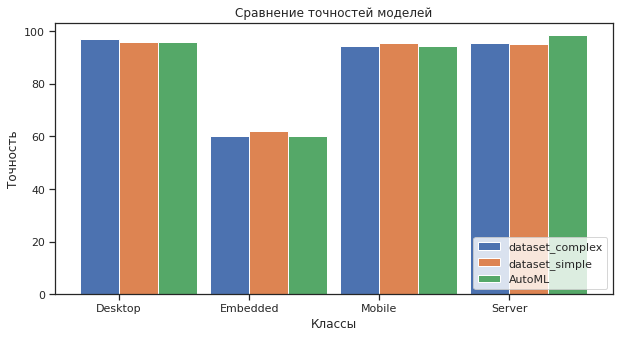

In [34]:
index = np.arange(len(dataset[y_name].value_counts()))
bar_width = 0.3
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(index, results["dataset_complex"].values(), bar_width, label="dataset_complex")
ax.bar(index + bar_width, results["dataset_simple"].values(), bar_width, label="dataset_simple")
ax.bar(index + 2 * bar_width, results["auto_ml"].values(), bar_width, label="AutoML")

ax.set_ylabel('Точность')
ax.set_xlabel('Классы')
ax.set_title("Сравнение точностей моделей")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(results["auto_ml"].keys())
ax.legend(loc = "lower right")

plt.show()